In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

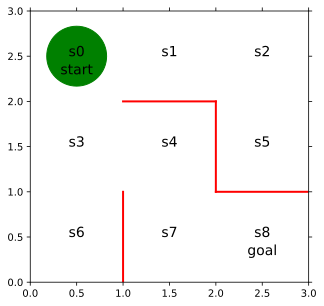

In [2]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.plot([1,1],[0,1],color='red',linewidth=2)
plt.plot([1,2],[2,2],color='red',linewidth=2)
plt.plot([2,2],[2,1],color='red',linewidth=2)
plt.plot([2,3],[1,1],color='red',linewidth=2)

plt.text( .5,2.5,'s0',size=14,ha='center')
plt.text(1.5,2.5,'s1',size=14,ha='center')
plt.text(2.5,2.5,'s2',size=14,ha='center')
plt.text( .5,1.5,'s3',size=14,ha='center')
plt.text(1.5,1.5,'s4',size=14,ha='center')
plt.text(2.5,1.5,'s5',size=14,ha='center')
plt.text( .5,0.5,'s6',size=14,ha='center')
plt.text(1.5, .5,'s7',size=14,ha='center')
plt.text(2.5, .5,'s8',size=14,ha='center')
plt.text( .5,2.3,'start',size=14,ha='center')
plt.text(2.5, .3,'goal',size=14,ha='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis='both',which='both',bottom='off',top='off',
                labelbottom='off',left='off',right='off',labelleft='off')

line, = ax.plot([ .5],[2.5],marker='o',color='g',markersize=60)

In [3]:
theta_0 = np.array([[np.nan, 1, 1, np.nan], # s0
                    [np.nan, 1, np.nan, 1], # s1
                    [np.nan, np.nan, 1, 1], # s2
                    [1     , 1, 1, np.nan], #s3
                    [np.nan, np.nan, 1, 1], #s4
                    [1, np.nan, np.nan, np.nan], # s5
                    [1, np.nan, np.nan, np.nan], # s6
                    [1, 1, np.nan, np.nan], # s7
                   ])

In [4]:
[a,b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0

def simple_convert_into_pi_from_theta(theta):
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0,m):
        pi[i,:] = theta[i,:] / np.nansum(theta[i,:])
    pi = np.nan_to_num(pi)
    return pi
pi_0 = simple_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [5]:
def get_action(s, Q, epsilon, pi):
    dire = {
        'up': 0,
        'right': 1,
        'down': 2,
        'left': 3
    }
    dire_arr = [i for i in dire.keys()]
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(dire_arr, p=pi[s,:])
    else:
        next_direction = dire_arr[np.nanargmax(Q[s,:])]
    return dire[next_direction]

def get_s_next(s, a, Q, epsilon, pi_0):
    dire = {
        'up': -3,
        'right': 1,
        'down': 3,
        'left': -1
    }
    return s + dire[[i for i in dire.keys()][a]]

In [6]:
def sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] += (eta*(r - Q[s, a]))
    else:
        Q[s,a] += (eta*(r+gamma * Q[s_next, a_next]- Q[s, a]))
    return Q

In [7]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s,s_a_history = 0, [[0, np.nan]]
    a = a_next = get_action(s, Q, epsilon, pi)
    
    while True:
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s, a, Q, epsilon, pi)
        s_a_history.append([s_next, np.nan])
        
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        Q = sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        
        if s_next == 8:
            break
        else:
            s = s_next
    return [s_a_history, Q]

In [8]:
# learning rate
eta = .1
# time discount
gamma = .9
# init val
epsilon = .5
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

while is_continue:
    epsilon = epsilon / 2
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    new_v = np.nanmax(Q, axis=1)
    v = new_v
    episode += 1
    if episode > 100:
        break
print(s_a_history)

[[0, 2], [3, 1], [4, 2], [7, 1], [8, nan]]


In [9]:
from matplotlib import animation
from IPython.display import HTML

state_history = s_a_history

def init():
    line.set_data([],[])
    return (line,)
def animate(i):
    state = state_history[i][0]
    x = (state % 3) + .5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)
anim = animation.FuncAnimation(fig, animate,init_func=init, 
                              frames=len(state_history),interval=200, repeat=False)
HTML(anim.to_jshtml())